In [15]:
pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [1]:
import os 
import torch
import cv2
import matplotlib.pyplot as plt
import glob
from torch.utils.data import DataLoader
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
import torch.nn as nn
from tqdm import tqdm 

Put bbox info in list of lists
make a label class id list 
make them tensor
https://pytorch.org/docs/stable/data.html

# Record the meeting

# Record the meeting


# Record the meeting


# Record the meeting

# Record the meeting

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/PSHS_Projects/crop_and_weed.zip","r") as zip_ref:
    zip_ref.extractall()

# Structure the data so that it can fed to the neural network

# How to do we extract bboxes from files

In [17]:
images = sorted(glob.glob("/content/agri_data/data/*.jpeg"))[:200]
text = sorted(glob.glob("/content/agri_data/data/*.txt"))[:200]

train_images, train_text = images[:int(len(images) * 0.8)], text[:int(len(text) * 0.8)]
test_images, test_text = images[int(len(images) * 0.8):], text[int(len(text) * 0.8):]

assert len(train_images) + len(test_images) == len(images)
for img_path in train_images: 
  assert img_path not in test_images

assert len(train_text) + len(test_text) == len(text)
for txt_path in train_text: 
  assert txt_path not in test_text 


classes = ['crop', 'weed'] # Crop is labeled 0 

def yolo2voc(yolo_bbox): 

  pascal_voc_bbox = [0, 0, 0, 0]
  pascal_voc_bbox[0] = (yolo_bbox[0] - yolo_bbox[2]/2) * 512
  pascal_voc_bbox[1] = (yolo_bbox[1] - yolo_bbox[3]/2) *512
  pascal_voc_bbox[2] = (yolo_bbox[0] + yolo_bbox[2]/2) *512
  pascal_voc_bbox[3] = (yolo_bbox[1] + yolo_bbox[3]/2) * 512

  return pascal_voc_bbox


class LoadAgriData(): 

  def __init__(self, full_images, full_text, transforms): 
    self.full_images = full_images
    self.full_text = full_text
    self.transforms = transforms
    
  def __getitem__(self, x): 
    image_file = self.full_images[x] 
    text_file = self.full_text[x]
    image_id = x 

    img = cv2.imread(image_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = []
    labels = []

    # Extract numbers from text file 
    with open(text_file) as f:
      lines = f.readlines()
      for bbox in lines: 
        lines_split = bbox.split()
        lines_split = [float(value) for value in lines_split]
        yolo_voc = lines_split[1:]
        label = lines_split[0]
        pascal_voc_bboxes = yolo2voc(yolo_voc)
        boxes.append(pascal_voc_bboxes)
        labels.append(label)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = torch.tensor(labels, dtype = torch.int64)
    target["image_id"] = torch.tensor(image_id, dtype = torch.int64)

    
    # This is where we have to use the output of get_tranforms to alter the image
    #Query about transforms for labels of images
    if self.transforms: 
      sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }

      sample = self.transforms(**sample)
      img = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return img, target

  def __len__(self): 
    return len(self.full_images)


def get_transforms(mode): 
  if mode == "train": 

    # A.OneOf makes the transform mutually exclusive.
    transforms = A.Compose([
                            A.OneOf([ 
                              A.RandomBrightnessContrast(p = 0.35),
                              A.ColorJitter(p = 0.35)
                            ]),
                            A.VerticalFlip(p = 0.35), 
                            A.HorizontalFlip(p = 0.35),  
                            ToTensorV2()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    return transforms

  elif mode == "test": 
    
    transforms = A.Compose([
                            ToTensorV2()], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    return transforms

  else: 
    raise ValueError("Please type either train or test")


# Did not implement function
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])

  # How do you get one at once

batch_size = 4

training_agri_data = LoadAgriData(train_images, train_text, get_transforms("train"))
testing_agri_data = LoadAgriData(test_images, test_text, get_transforms("test"))

training_agriDataLoader = DataLoader(training_agri_data, batch_size= batch_size, shuffle=True, collate_fn= collate_fn)
testing_agriDataLoader = DataLoader(testing_agri_data, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

IndexError: ignored

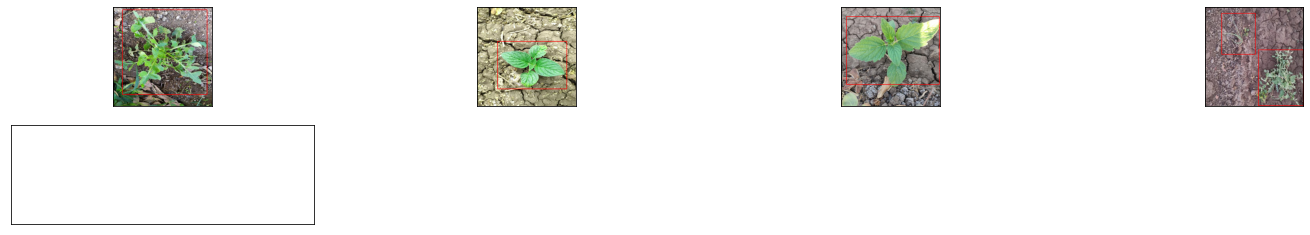

In [18]:
agridata_iterator = iter(training_agriDataLoader)
img, labels = agridata_iterator.next()

def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    for i, box in enumerate(boxes):
        # (R, G, B)
        color = (255, 0, 0)
        cv2.rectangle(image, (int(box[0]), int(box[1])), \
        (int(box[2]), int(box[3])), color, 2)
        
        # cv2.putText(image, classes[labels[i - 1]], (int(box[0]), int(box[1])-5),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
        #             lineType=cv2.LINE_AA)
    return image

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    drawing_img = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], img[idx])
    plt.imshow(drawing_img)

In [19]:
# Initialize Model: 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [5]:
# How do you alter models

model.roi_heads.box_predictor.cls_score = nn.Linear(model.roi_heads.box_predictor.cls_score.in_features, 2) # 2 classes: Weed and Crop
model.roi_heads.box_predictor.bbox_pred = nn.Linear(model.roi_heads.box_predictor.bbox_pred.in_features, 2 * 4) # 2 classes: Weed and Crop * 4: 

In [ ]:
imgs = np.ones((8, 3, 32, 32))
imgs = torch.from_numpy(imgs)
model.eval()
model(imgs.float())

In [ ]:
def load_model_from_weights(weights): 
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

  model.roi_heads.box_predictor.cls_score = nn.Linear(model.roi_heads.box_predictor.cls_score.in_features, 2) # 2 classes: Weed and Crop
  model.roi_heads.box_predictor.bbox_pred = nn.Linear(model.roi_heads.box_predictor.bbox_pred.in_features, 2 * 4) # 2 classes: Weed and Crop * 4: 


# Way you find accuracy in object detection: 

Is calculating the mAP (mean Average Precision) of your model

# What is a state dict

A state dict is a dictionary of all the important parameters in a model

In [21]:
# Train the model

epochs = 10
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) # condensed if statement (if we have GPU)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)
os.mkdir("Saved_Weights1")

for epoch in range(epochs): 

  epoch_train_loss = 0
  epoch_valid_loss = 0 
  num_of_train_images = 0
  num_of_valid_images = 0 
  
  # iterate through our data loader 
  for images, labels in tqdm(training_agriDataLoader): 

    num_of_train_images += len(images)

    model.train()

    # Moves all image and target data to the GPU (Cuda)
    images = torch.stack(images).to(device)
    for lab in labels: 
     for k in list(lab.keys()): 
       if k == "boxes": 
         lab[k] = lab[k].to(device)
       elif (k == "labels"):
         lab[k] = torch.tensor(lab[k]).to(device)
    
    optimizer.zero_grad()

    loss_dict = model(images.float(), labels) # feedforward and loss
    train_loss = sum(list(loss_dict.values())) # one value loss
    train_loss.backward() # backpropagation - calculates the derivatives (gradients)
    optimizer.step() #  go down the weight vs error curve by subtracting the gradients * learning rate
    epoch_train_loss += train_loss.item()
  
  
  for images, labels in tqdm(testing_agriDataLoader): 
    # Built the validation portion of the cell

    num_of_valid_images += len(images) 

    model.train()
    images = torch.stack(images).to(device)
    for lab in labels: 
     for k in list(lab.keys()): 
       if k == "boxes": 
         lab[k] = lab[k].to(device)
       elif (k == "labels"):
         lab[k] = torch.tensor(lab[k]).to(device)
    
    loss_dict = model(images.float(), labels) # feedforward and loss
    valid_loss = sum(list(loss_dict.values())) # one value loss

    epoch_valid_loss += valid_loss.item()

    model.eval()
    output = model(images.float())

  torch.save(model.state_dict(), "./Saved_Weights/model{}.pth".format(epoch))


  
  print("Epoch: {} Train Loss: {}".format(epoch, epoch_train_loss / num_of_train_images))
  print("Epoch: {} Valid Loss: {}".format(epoch, epoch_valid_loss / num_of_valid_images))



100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch: 0 Train Loss: 307.44721151178527
Epoch: 0 Valid Loss: 3.3923066323946465


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch: 1 Train Loss: 23.644772464657073
Epoch: 1 Valid Loss: 4.408863200564384


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch: 2 Train Loss: 13.716709769296116
Epoch: 2 Valid Loss: 1.9023457009726363


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch: 3 Train Loss: 620.0467499348654
Epoch: 3 Valid Loss: 129.8013548490773


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch: 4 Train Loss: 1362.1833603766067
Epoch: 4 Valid Loss: 623.5668212630083


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch: 5 Train Loss: 467.0294576009349
Epoch: 5 Valid Loss: 13.496349600430097


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch: 6 Train Loss: 17.89591285098903
Epoch: 6 Valid Loss: 3.133005165008091


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch: 7 Train Loss: 47.82637516010704
Epoch: 7 Valid Loss: 12.345656403144664


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch: 8 Train Loss: 12.502768558105956
Epoch: 8 Valid Loss: 4.975485478335285


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch: 9 Train Loss: 13.481112967295406
Epoch: 9 Valid Loss: 15.193156008680598


In [33]:
a = torch.tensor(10)
a = a.cuda()

In [ ]:
a = torch.tensor(0.98)
a.item()

0.9800000190734863

In [ ]:
a = {'a': 3, 'b': 5}
a.keys()

dict_keys(['a', 'b'])

In [ ]:
len(data[0])

8

In [ ]:
def generator(a):
  for num in a: 
    yield num + 10

a = [1, 2, 3, 4, 5]
our_generator = generator(a)


In [ ]:
our_generator

<generator object generator at 0x7f9861463cd0>

In [ ]:
iter_generator = iter(our_generator)


In [ ]:
next(iter_generator)

StopIteration: ignored

In [ ]:
agri_data = LoadAgriData(images, text)

len(agri_data)

1300

# Delete Hard coded thing

In [ ]:
building = BluePrint()

building[8]

In [ ]:
entire_data = [1, 2, 3, 4, 5, 6, 7, 8]

entire_data[0]

1

In [ ]:
class BluePrint(): 
  def __init__(self, size, color, durability, location = "Phillipines"): 
    self.color = color
    self.size = size
    self.location = location
  
  def rebuild(self): 
    print("I am going to rebuild")

  def shutdown(self, time): 
    print("Shutdown for time: {}".format(time))

  def __getitem__(self, x): 
    print(x)


In [ ]:
building = BluePrint(size = 10, color = "RED", durability = "hard")

In [ ]:
building[]

10


In [ ]:
building.location

'Phillipines'